<figure>
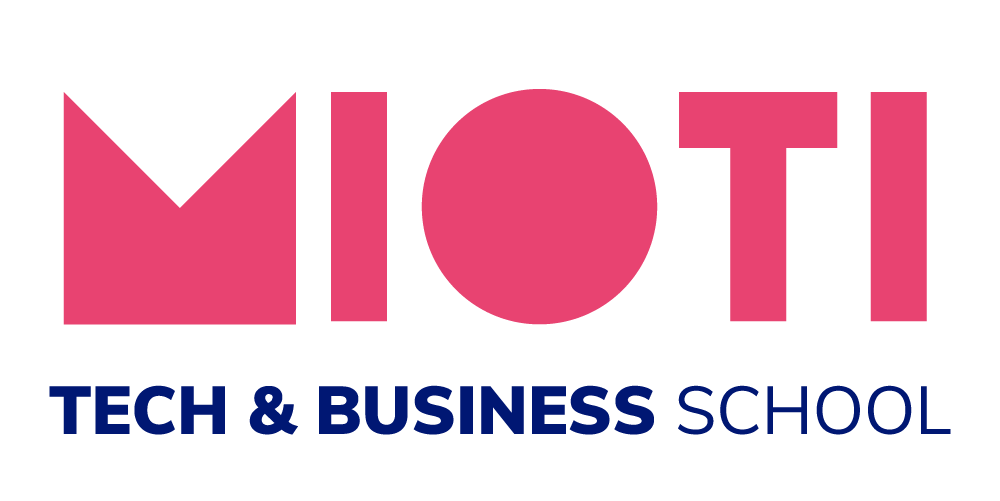
<figcaption></figure>

# Deep Learning

### Deep Convolutional Generative Adversarial Network

## Objective

The objective of this notebook is to implement and train a Generative Adversarial Network (GAN) using the CIFAR dataset. The aim is to construct a model where the generator creates images from noise, and the discriminator classifies these images as real or fake. The training process involves alternating between updating the generator and discriminator to improve their performance iteratively. By the end of the training, the goal is to have a GAN capable of generating realistic images that closely resemble those in the CIFAR dataset.

CIFAR-10 Database: https://www.cs.toronto.edu/~kriz/cifar.html

## 1. Environment Setup

Let's load the libraries that we will use for the challenge.

In [ ]:
# Tensorflow
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Other libraries
import os
import PIL
import time
import glob
import imageio
import numpy as np
import matplotlib.pyplot as plt

from IPython import display

In [ ]:
# Library for GIFs generetion
!pip install -q imageio

## 2. Data Loading and Preprocessig

Let's use the CIFAR dataset to train the generator and the discriminator.

In [ ]:
tfds.list_builders()
builder = tfds.builder("cifar10")
builder.download_and_prepare()

In [ ]:
print(builder.info)

In [ ]:
(train_dataset_raw) = builder.as_dataset(split="train", as_supervised=True)

In [ ]:
def format_example(image, label):
  image = tf.cast(image, tf.float32)
  # scale from [0,255] to [-1,1]
  image = (image - 127.5) / 127.5
  image = tf.image.resize(image, (32, 32))
  return image, label

In [ ]:
train_dataset = train_dataset_raw.map(format_example)

In [ ]:
for image, label in train_dataset.take(1):
  plt.imshow(image, interpolation='nearest')

In [ ]:
i = 0
for image, label in train_dataset.take(49):
  # define subplot
  plt.subplot(7, 7, 1 + i)
  # turn off axis
  plt.axis('off')
  # plot raw pixel data
  image = (image + 1) / 2.0
  plt.imshow(image)
  i = i + 1
plt.show()

## Model creation

Both the generator and discriminator will be defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### Generator
The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). It starts with a Dense layer that takes the seed as input, then upscales (upsamples) it several times until reaching the desired image size of 32x32x3. We will use `tf.keras.layers.LeakyReLU` activation layers, except for the output layer, which will use `tanh`.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

In [ ]:
generator = make_generator_model()
generator.summary()

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

In [ ]:
plt.imshow((generated_image[0, :, :, :] + 1) / 2)

### Discriminator

The discriminator is an image classifier based on CNNs.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print(decision)

### Definition of the Cost Function and Optimizer

We define the cost function and optimizers for both models.

In [ ]:
# This method returns a helper function to calculate cross-entropy loss.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Discriminator Cost Function

This method quantifies how well the discriminator is able to distinguish between real and fake images. It compares the predictions of real images with an array of 1s, and the predictions of fake images with an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### Generator Cost Function

The generator's cost function quantifies how well it can deceive the discriminator. Intuitively, if the generator performs well, the discriminator will be fooled. Here, we compare the discriminator's decisions on fake images with an array of 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and generator will have separate optimizers since we will train these networks independently.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

### Save Checkpoints

This notebook also demonstrates how to save and restore models, which can be very useful in case training is paused or if we want to use the models later.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Defining the Training Loop


In [ ]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 49

seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop starts with the generator receiving a random seed as input. This seed is used to produce an image. The discriminator is then used to classify real images (from the dataset) and fake images (produced by the generator). The cost is calculated for each network separately, and the weights are updated using gradient descent.

In [ ]:
# Here we use tf.function
# This compiles the function.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch, label_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF on the fly
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Save the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

  # Generate after each epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)


### Generating and saving images


In [ ]:
def generate_and_save_images(model, epoch, test_input):
    # Note that `training` is set to False.
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(7,7))

    for i in range(predictions.shape[0]):
        plt.subplot(7, 7, 1 + i)
        image = (predictions[i, :, :, :] + 1) / 2.0
        plt.imshow(image)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch, label_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF on the fly
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    # Generate after each epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

## Training the Model

We call the previously defined `train()` function to simultaneously train the generator and the discriminator. Training GANs is complex, and it's important that the generator and the discriminator do not significantly outperform each other (both should train at a similar pace).

At the beginning of the training, the generated images will look like random noise. As training progresses, the generated digits will start to look more real.

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256
train_dataset_shuffled = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train(train_dataset_shuffled, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## GIF creation


In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

We use `imageio` to create an animated GIF with these images.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

If you are working on Colab, its possible to download it with the following code:

In [ ]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)